***NOTE: This notebook is work in progress.

# Data Preperation

The cell below is the necessary steps to prepare data for modeling. Please see the EDA notebook for details.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tools.eval_measures import rmse, aic
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from keras import models, layers, optimizers, regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, LeakyReLU

tf.random.set_seed(3)
np.random.seed(3)

In [2]:
### Electricity Consumption Dataset ###

preview_e = pd.read_csv("Electric_Consumption_And_Cost__2010_-_April_2020_.csv")

preview_e['DATE'] = pd.to_datetime(preview_e['Service End Date'], format="%m/%d/%Y")

preview_e.set_index('DATE', inplace=True)

Manhattan = preview_e.loc[preview_e['Borough'] == 'MANHATTAN']

electric_manhattan = Manhattan.resample('MS').mean()

electric_manhattan = pd.DataFrame(electric_manhattan['Consumption (KWH)'])

### Weather Dataset ### 

preview_w = pd.read_csv('nyc_weather.csv')

preview_w['DATE'] = pd.to_datetime(preview_w['DATE'], format="%Y/%m")

keep = ['DATE', 'NAME', 'CDSD', 'EMNT', 'EMXT', 'HDSD', 'TAVG', 'TMAX', 'TMIN']

preview_w = preview_w[keep]

preview_w = preview_w.rename(columns={'CDSD': 'Cooling Degree Days Season',
                                      'EMNT': 'Extreme Minimum Temperature',
                                      'EMXT': 'Extreme Maximum Temperature',
                                      'HDSD': 'Heating Degree Days Season',
                                      'TAVG': 'Average Temperature',
                                      'TMAX': 'Maximum Temperature',
                                      'TMIN': 'Minimum Temperature'})

preview_w.set_index('DATE', inplace=True)

central_park = preview_w.loc[preview_w['NAME'] == 'NY CITY CENTRAL PARK, NY US']    

weather_central_park = central_park.resample('MS').mean()

weather_central_park = weather_central_park.loc[:'2021-02-01']

### Merge Datasets ###

manhattan_data = electric_manhattan.merge(weather_central_park, left_index=True, right_index=True)

### Train-Validation-Test Split ###

dataset = manhattan_data['2012-01-01':]
data = manhattan_data['2012-01-01':'2017-12-01'] 
train = data[:'2016-12-01']
val = data['2017-01-01':]
test = manhattan_data['2019-01-01':]

print('manhattan_data shape: ', manhattan_data.shape)
print('data shape: ', data.shape)
print('train shape: ', train.shape)
print('val shape: ', val.shape)
print('test shape: ', test.shape)

### List of Previous Models' Performance ###

performance = ['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
               'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
               'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
               'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%',
               'VARMAX test (train1) - RMSE: 6,227. MAPE: 16%',
               'VARMAX test (train2) - RMSE: 5,639. MAPE: 14%']

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


manhattan_data shape:  (134, 8)
data shape:  (72, 8)
train shape:  (60, 8)
val shape:  (12, 8)
test shape:  (26, 8)


In [3]:
# evaluating the forecasts
def adjust(val, length= 6): 
    return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

# converting input data into 3-D array as required for LSTM network
def split_sequence(sequence, n_steps):    
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Modeling

This time, I will try to train the data using LSTM (Long Short Term Memory) models. The LSTM model can model problems with multiple input variables. The key to LSTM modeling is that you have to scale the data before fitting.

For the evaluation metrics, I will focus on RMSE (Root Mean Squared Error), which will show how much kWh are off.

In [4]:
dataset_values = dataset.values

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))

In [6]:
scaled_data = scaler.fit_transform(dataset_values)

In [7]:
train_data = scaled_data[:60]
val_data = scaled_data[60:72]
test_data = scaled_data[-26:]
len(train_data), len(val_data), len(test_data)

(60, 12, 26)

In [8]:
features = 8
n_steps = 10

In [9]:
X_train, y_train = split_sequence(train_data, n_steps)
X_test, y_test = split_sequence(test_data, n_steps)
X_val, y_val = split_sequence(val_data, n_steps)

In [10]:
X_train.shape, y_train.shape

((50, 10, 8), (50, 8))

In [11]:
early = EarlyStopping(monitor='val_loss',patience=5)

# reduce learning rate when a metric has stopped improving
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [12]:
test_data.shape

(26, 8)

In [13]:
y_test_re = scaler.inverse_transform(y_test)
y_test_re.shape

(16, 8)

## Model 1 with RepeatVector

In [14]:
model1 = Sequential()
model1.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps, features)))
model1.add(RepeatVector(n_steps))
model1.add(LSTM(128, activation='relu', return_sequences=False))
model1.add(Dense(features))

model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [15]:
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(X_val, y_val), callbacks=[early,reduce])

Epoch 1/50
1/1 [==============================] - 0s 299ms/step - loss: 0.3751 - mean_squared_error: 0.3751 - val_loss: 0.1825 - val_mean_squared_error: 0.1825
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3533 - mean_squared_error: 0.3533 - val_loss: 0.1642 - val_mean_squared_error: 0.1642
Epoch 3/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3317 - mean_squared_error: 0.3317 - val_loss: 0.1455 - val_mean_squared_error: 0.1455
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Epoch 5/50
1/1 [==============================] - 0s 32ms/step - loss: 0.2838 - mean_squared_error: 0.2838 - val_loss: 0.1045 - val_mean_squared_error: 0.1045
Epoch 6/50
1/1 [==============================] - 0s 32ms/step - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.0818 - val_mean_squared_error: 0.0818
Epoch 7/50
1/1 [=============================

In [16]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               70144     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
Total params: 202,760
Trainable params: 202,760
Non-trainable params: 0
_________________________________________________________________


In [17]:
# forecasting test set
y_pred1 = model1.predict(X_test)

y_pred1_inv = scaler.inverse_transform(y_pred1)
y_test_inv = scaler.inverse_transform(y_test)

rmse1 = np.sqrt(np.mean(((y_pred1_inv-y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：3153.895


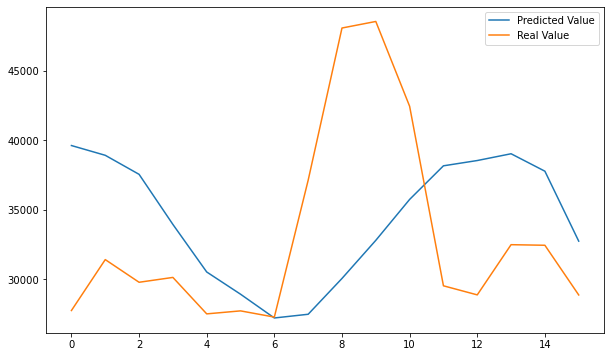

In [18]:
prediction = pd.DataFrame(y_pred1_inv)
testdata= pd.DataFrame(y_test_re)
prediction = prediction.iloc[:, 0].values
testdata = testdata.iloc[:, 0].values

plt.figure(figsize=(10,6))

plt.plot(prediction)
plt.plot(testdata)
plt.legend(['Predicted Value', 'Real Value']);

In [19]:
performance.append('LSTM1 test (train2) - RMSE: 3,154.')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%',
 'VARMAX test (train1) - RMSE: 6,227. MAPE: 16%',
 'VARMAX test (train2) - RMSE: 5,639. MAPE: 14%',
 'LSTM1 test (train2) - RMSE: 3,154.']

## Model 2 with Dropout

In [20]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(n_steps, features), return_sequences=True))
model2.add(LSTM(32, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(features))

model2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [21]:
history2=model2.fit(X_train, y_train, epochs=50, validation_data =(X_val, y_val))

Epoch 1/50
2/2 [==============================] - 1s 332ms/step - loss: 0.3242 - accuracy: 0.3800 - val_loss: 0.1440 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 19ms/step - loss: 0.2505 - accuracy: 0.3200 - val_loss: 0.1023 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 22ms/step - loss: 0.2003 - accuracy: 0.3800 - val_loss: 0.0817 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 0.1582 - accuracy: 0.3800 - val_loss: 0.0816 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 26ms/step - loss: 0.1382 - accuracy: 0.2000 - val_loss: 0.0973 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 24ms/step - loss: 0.1230 - accuracy: 0.1200 - val_loss: 0.1057 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 0s 24ms/step - loss: 0.1263 - accuracy: 0.0600 - val_loss: 0.0997 - val_accuracy: 0.0000e+0

In [22]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 64)            18688     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 31,368
Trainable params: 31,368
Non-trainable params: 0
_________________________________________________________________


In [23]:
y_pred2= model2.predict(X_test)

y_pred2_inv = scaler.inverse_transform(y_pred2)

rmse2 = np.sqrt(np.mean(((y_pred2_inv-y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse2, 4)}')

RMSE：1563.0991


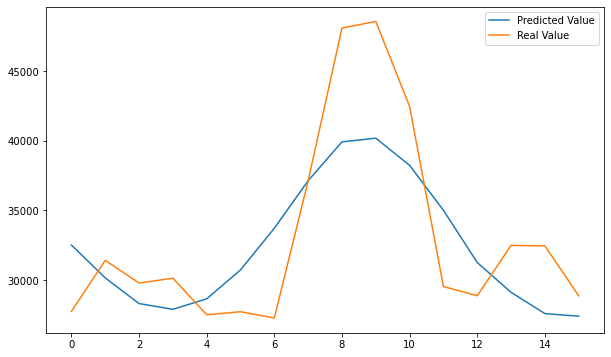

In [24]:
prediction2 = pd.DataFrame(y_pred2_inv)
prediction2 = prediction2.iloc[:, 0].values

plt.figure(figsize=(10,6))

plt.plot(prediction2)
plt.plot(testdata)
plt.legend(['Predicted Value', 'Real Value']);

In [25]:
performance.append('LSTM2 test (train2) - RMSE: 1,563.')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%',
 'VARMAX test (train1) - RMSE: 6,227. MAPE: 16%',
 'VARMAX test (train2) - RMSE: 5,639. MAPE: 14%',
 'LSTM1 test (train2) - RMSE: 3,154.',
 'LSTM2 test (train2) - RMSE: 1,563.']

## Model with LeakyReLU

In [26]:
model3 = Sequential()
model3.add(LSTM(128, return_sequences=True, input_shape=(n_steps, features)))
model3.add(LeakyReLU(alpha=0.5))
model3.add(LSTM(128, return_sequences=True))
model3.add(LeakyReLU(alpha=0.5))
model3.add(Dropout(0.3))
model3.add(LSTM(64, return_sequences=False))
model3.add(Dropout(0.3))
model3.add(Dense(features))

model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', ])

In [27]:
history3 = model3.fit(X_train, y_train, epochs=50, validation_data =(X_val, y_val), callbacks=[early,reduce])

Epoch 1/50
2/2 [==============================] - 1s 490ms/step - loss: 0.3540 - mean_squared_error: 0.3540 - val_loss: 0.1448 - val_mean_squared_error: 0.1448
Epoch 2/50
2/2 [==============================] - 0s 25ms/step - loss: 0.2824 - mean_squared_error: 0.2824 - val_loss: 0.0986 - val_mean_squared_error: 0.0986
Epoch 3/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2045 - mean_squared_error: 0.2045 - val_loss: 0.0787 - val_mean_squared_error: 0.0787
Epoch 4/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1516 - mean_squared_error: 0.1516 - val_loss: 0.1099 - val_mean_squared_error: 0.1099
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 0.1672 - mean_squared_error: 0.1672 - val_loss: 0.0928 - val_mean_squared_error: 0.0928
Epoch 6/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1328 - mean_squared_error: 0.1328 - val_loss: 0.0580 - val_mean_squared_error: 0.0580
Epoch 7/50
2/2 [=============================

In [28]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 128)           70144     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [29]:
y_pred3= model3.predict(X_test)

In [30]:
y_pred3_inv = scaler.inverse_transform(y_pred3)

rmse3 = np.sqrt(np.mean(((y_pred3_inv-y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse3, 4)}')

RMSE：2572.3795


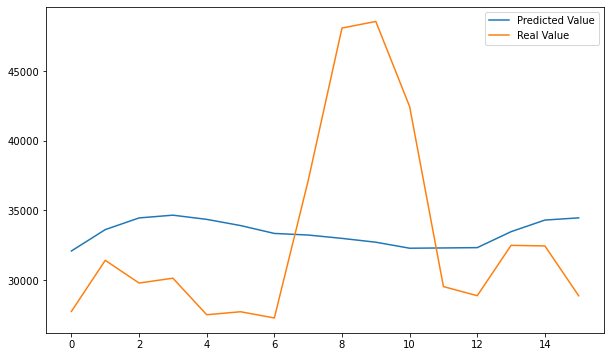

In [31]:
prediction = pd.DataFrame(y_pred3_inv)
prediction = prediction.iloc[:, 0].values

plt.figure(figsize=(10,6))

plt.plot(prediction)
plt.plot(testdata)
plt.legend(['Predicted Value', 'Real Value']);

In [32]:
performance.append('LSTM3 test (train2) - RMSE: 2,572.')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%',
 'VARMAX test (train1) - RMSE: 6,227. MAPE: 16%',
 'VARMAX test (train2) - RMSE: 5,639. MAPE: 14%',
 'LSTM1 test (train2) - RMSE: 3,154.',
 'LSTM2 test (train2) - RMSE: 1,563.',
 'LSTM3 test (train2) - RMSE: 2,572.']